<h1 align="center">Volume 4: Solitons.</h1>

    Caelan Osman
    Section 1
    March 6, 2022

In [1]:
from math import sqrt, pi
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

In [2]:
def initialize_all(y0, t0, t1, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size),dtype=complex).squeeze()
    else:
        Y = np.empty(n,dtype=complex)
    Y[0] = y0
    T = np.linspace(t0, t1, n)
    h = float(t1 - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t1, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    'y0' is assumed to be either a constant or a one-dimensional numpy array.
    't0' and 't1' are assumed to be constants.
    'f' is assumed to accept two arguments.
    The first is a constant giving the current value of t.
    The second is a one-dimensional numpy array of the same size as y.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y, T, h = initialize_all(y0, t0, t1, n)
    for i in range(1, n):
        K1 = f(T[i-1], Y[i-1])
        tplus = (T[i] + T[i-1]) * .5
        K2 = f(tplus, Y[i-1] + .5 * h * K1)
        K3 = f(tplus, Y[i-1] + .5 * h * K2)
        K4 = f(T[i], Y[i-1] + h * K3)
        Y[i] = Y[i-1] + (h / 6.) * (K1 + 2 * K2 + 2 * K3 + K4)
    return T, Y

# Problem 1

Run the code above to numerically solve the KdV equation on $[−π, π]$ with initial
conditions
$$u(x, t = 0) = 3s\,\mathrm{sech}^2
\left(\frac{\sqrt{s}}{2}(x + a)\right),$$

where $s = 25^2$
, $a = 2$. Solve on the time domain $[0, .0075]$. 
Plot the solution.

<IPython.core.display.Javascript object>


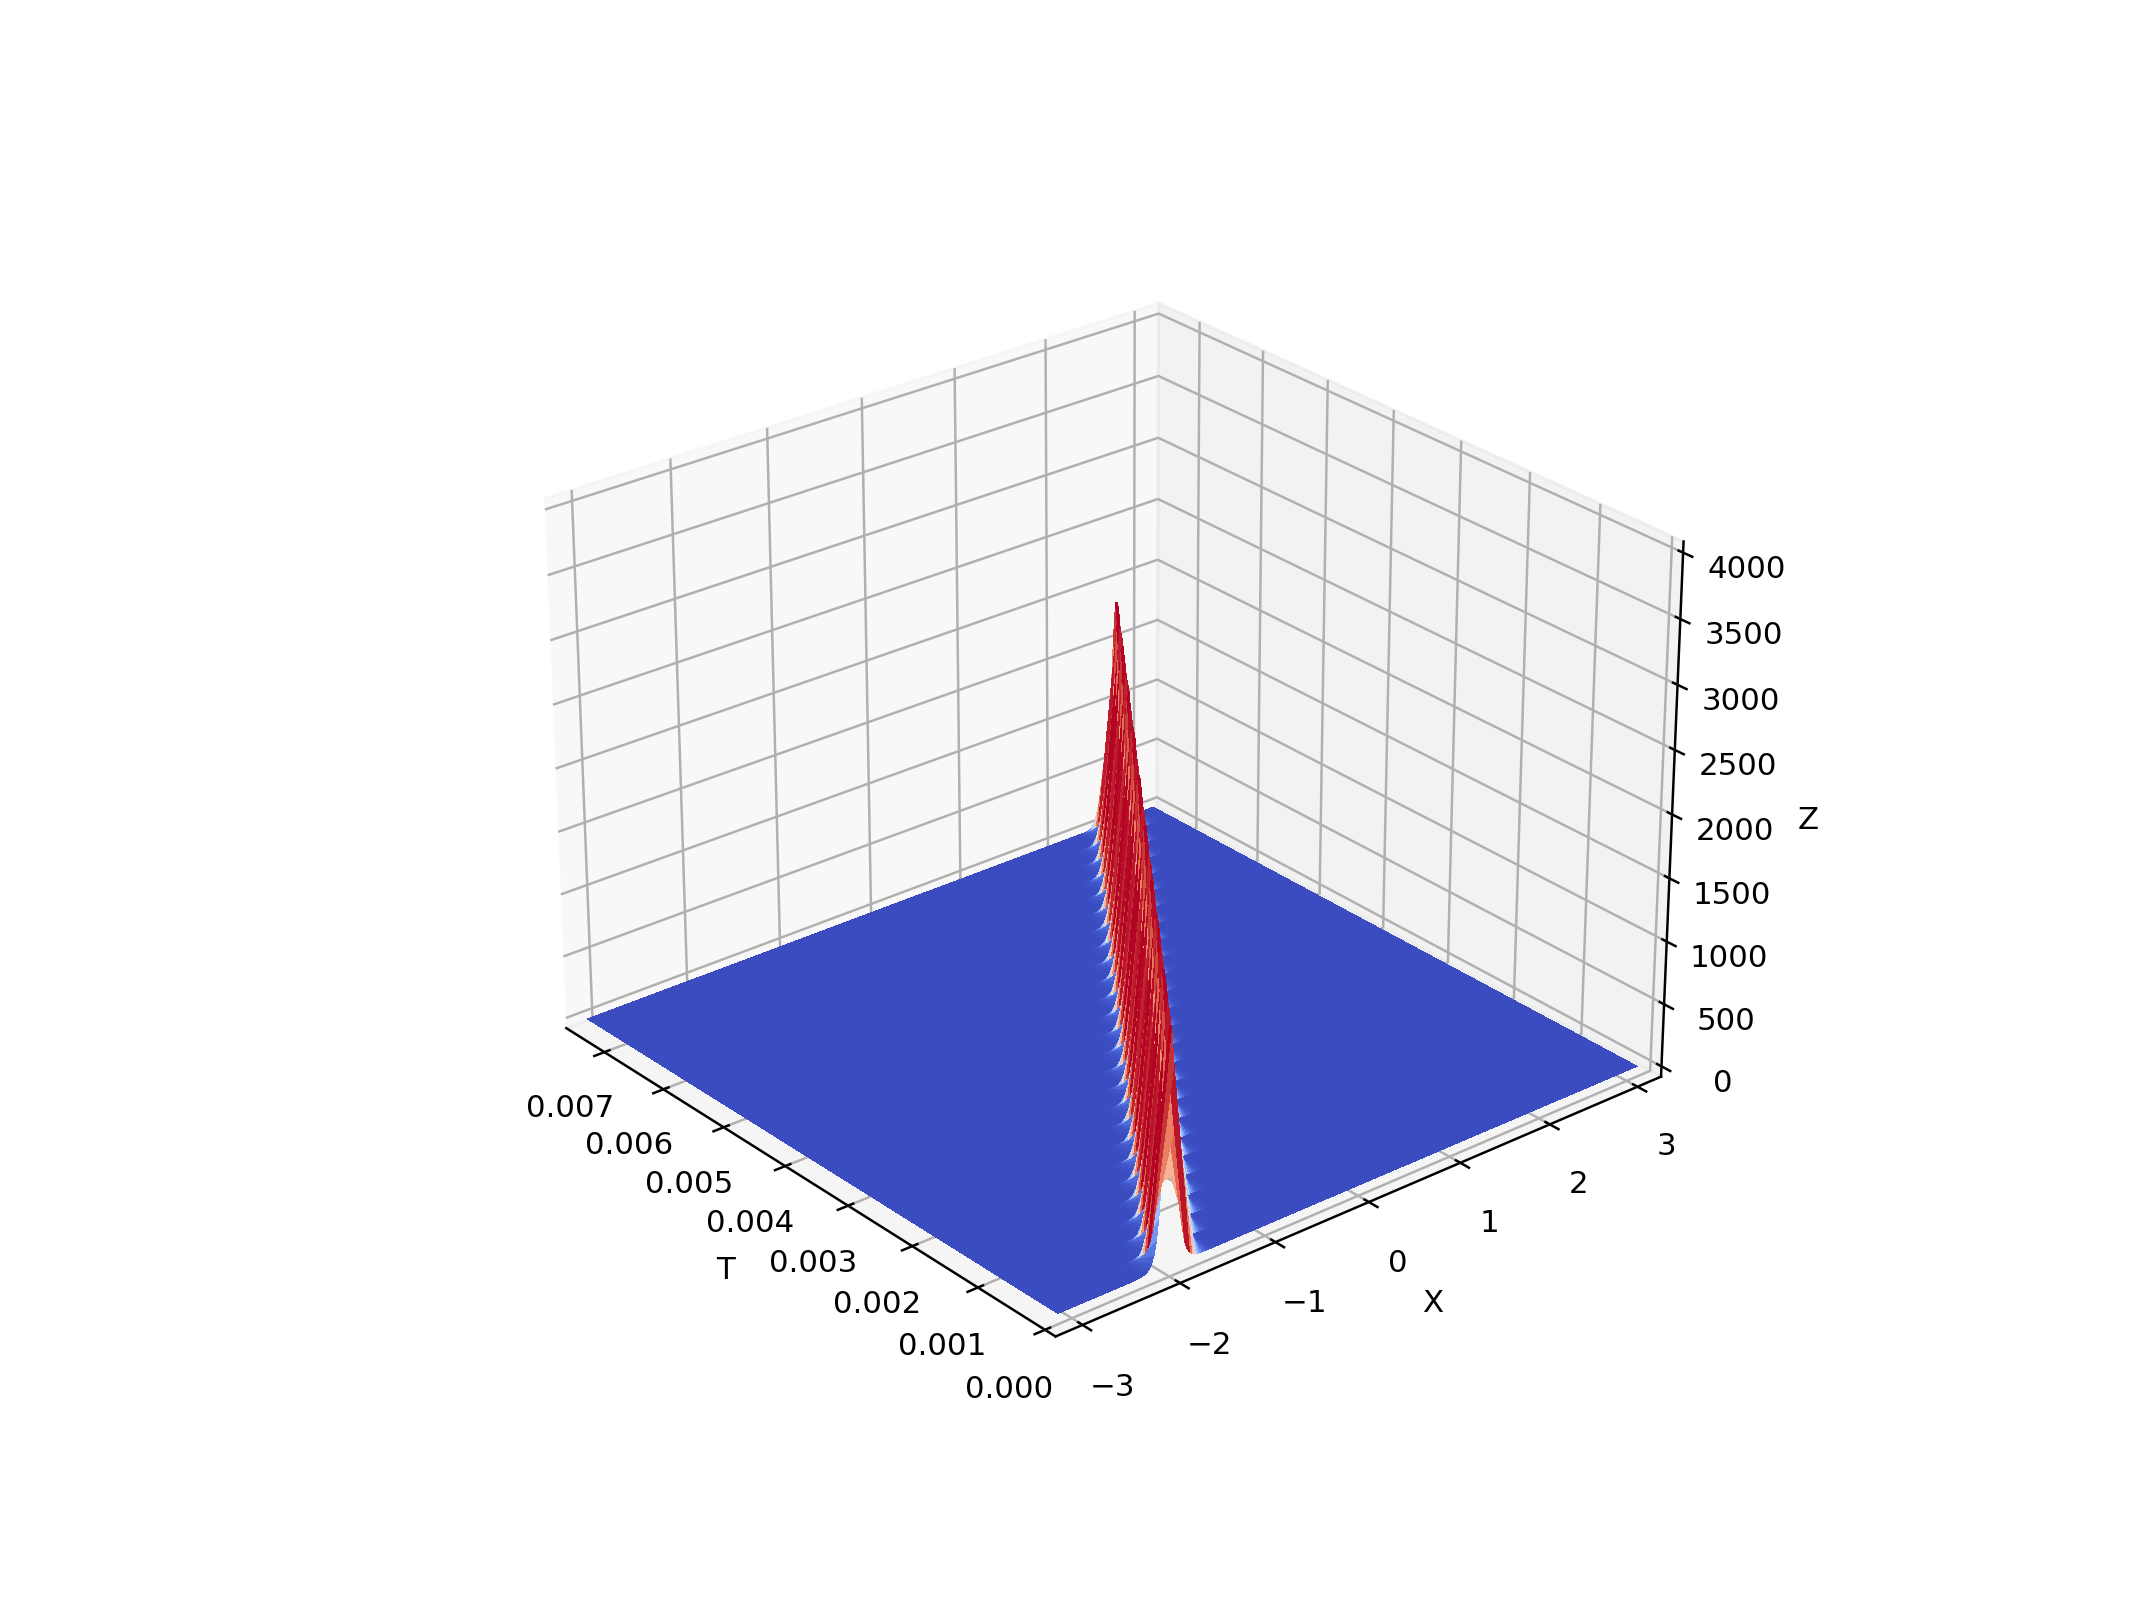

In [3]:
def problem1(s = 25**2, shift=2, N=256):
    
    # Space discretization
    x = (2.*np.pi/N)*np.arange(-N/2, N/2).reshape(N, 1) 
    
    # wave numbers
    k = np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0, 1))).reshape(N,)
    ik3 = 1j*k**3.
    
    # initial condition
    y0 = 3*s/(np.cosh(np.sqrt(s)*(x + shift)/2)**2).reshape(N,)
   
    # ODE to solve for Y in Fourier space. 
    def G_unscaled(t,y):
        out = -.5*1j*k*fft(ifft(y, axis=0)**2., axis=0) + ik3*y
        return out

    # Solves the ODE.
    max_t = .0075
    dt = .02*N**(-2.)
    max_tsteps = int(round(max_t/dt))
    # convert y0 to Fourier space
    y0 = fft(y0,axis=0)
    # solve for Y
    T, Y = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)
    # Using the variable stride, we step through the data,
    # applying the inverse fourier transform to obtain u.
    # These values will be plotted.
    stride = int(np.floor((max_t/25.)/dt))
    uvalues, tvalues = np.real(ifft(y0, axis=0)).reshape(N,1), np.array(0.).reshape(1, 1)
    for n in range(1, max_tsteps+1):
        if np.mod(n, stride) == 0:
            t = n*dt
            u = np.real(ifft(Y[n], axis=0) ).reshape(N,1)
            uvalues = np.concatenate((uvalues, np.nan_to_num(u)), axis=1)
            tvalues = np.concatenate((tvalues, np.array(t).reshape(1,1)), axis=1)
    # plot
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.gca(projection='3d')
    ax.view_init(elev=45., azim=150)
    tv, xv = np.meshgrid(tvalues, x, indexing='ij')
    surf = ax.plot_surface(tv, xv, uvalues.T, rstride=1, cstride=1, 
                           cmap=cm.coolwarm, linewidth=0, antialiased=False)
    tvalues = tvalues[0]; ax.set_xlim(tvalues[0], tvalues[-1])
    ax.set_ylim(pi, -pi);
    ax.set_zlim(0., 4000.)
    ax.set_xlim(0., 0.0075)
    ax.set_xlabel('T'); ax.set_ylabel('X'); ax.set_zlabel('Z')
    plt.show()
    return

problem1()

# Problem 2

Numerically solve the KdV equation on $[−π, π]$. This time we de
ne the initial
condition to be the superposition of two solitons,
$$u(x,t=0) = 3s_1\mathrm{sech}^2\left(\frac{\sqrt{s_1}}{2}(x+a_1)\right) + 3s_2\mathrm{sech}^2\left(\frac{\sqrt{s_2}}{2}(x+a_2)\right),
$$

where $s_1 = 25^2$
, $a_1 = 2$, and $s_2 = 16^2$
, $a_2 = 1$.
Solve on the time domain $[0, .0075]$. 
Plot the solution.

<IPython.core.display.Javascript object>


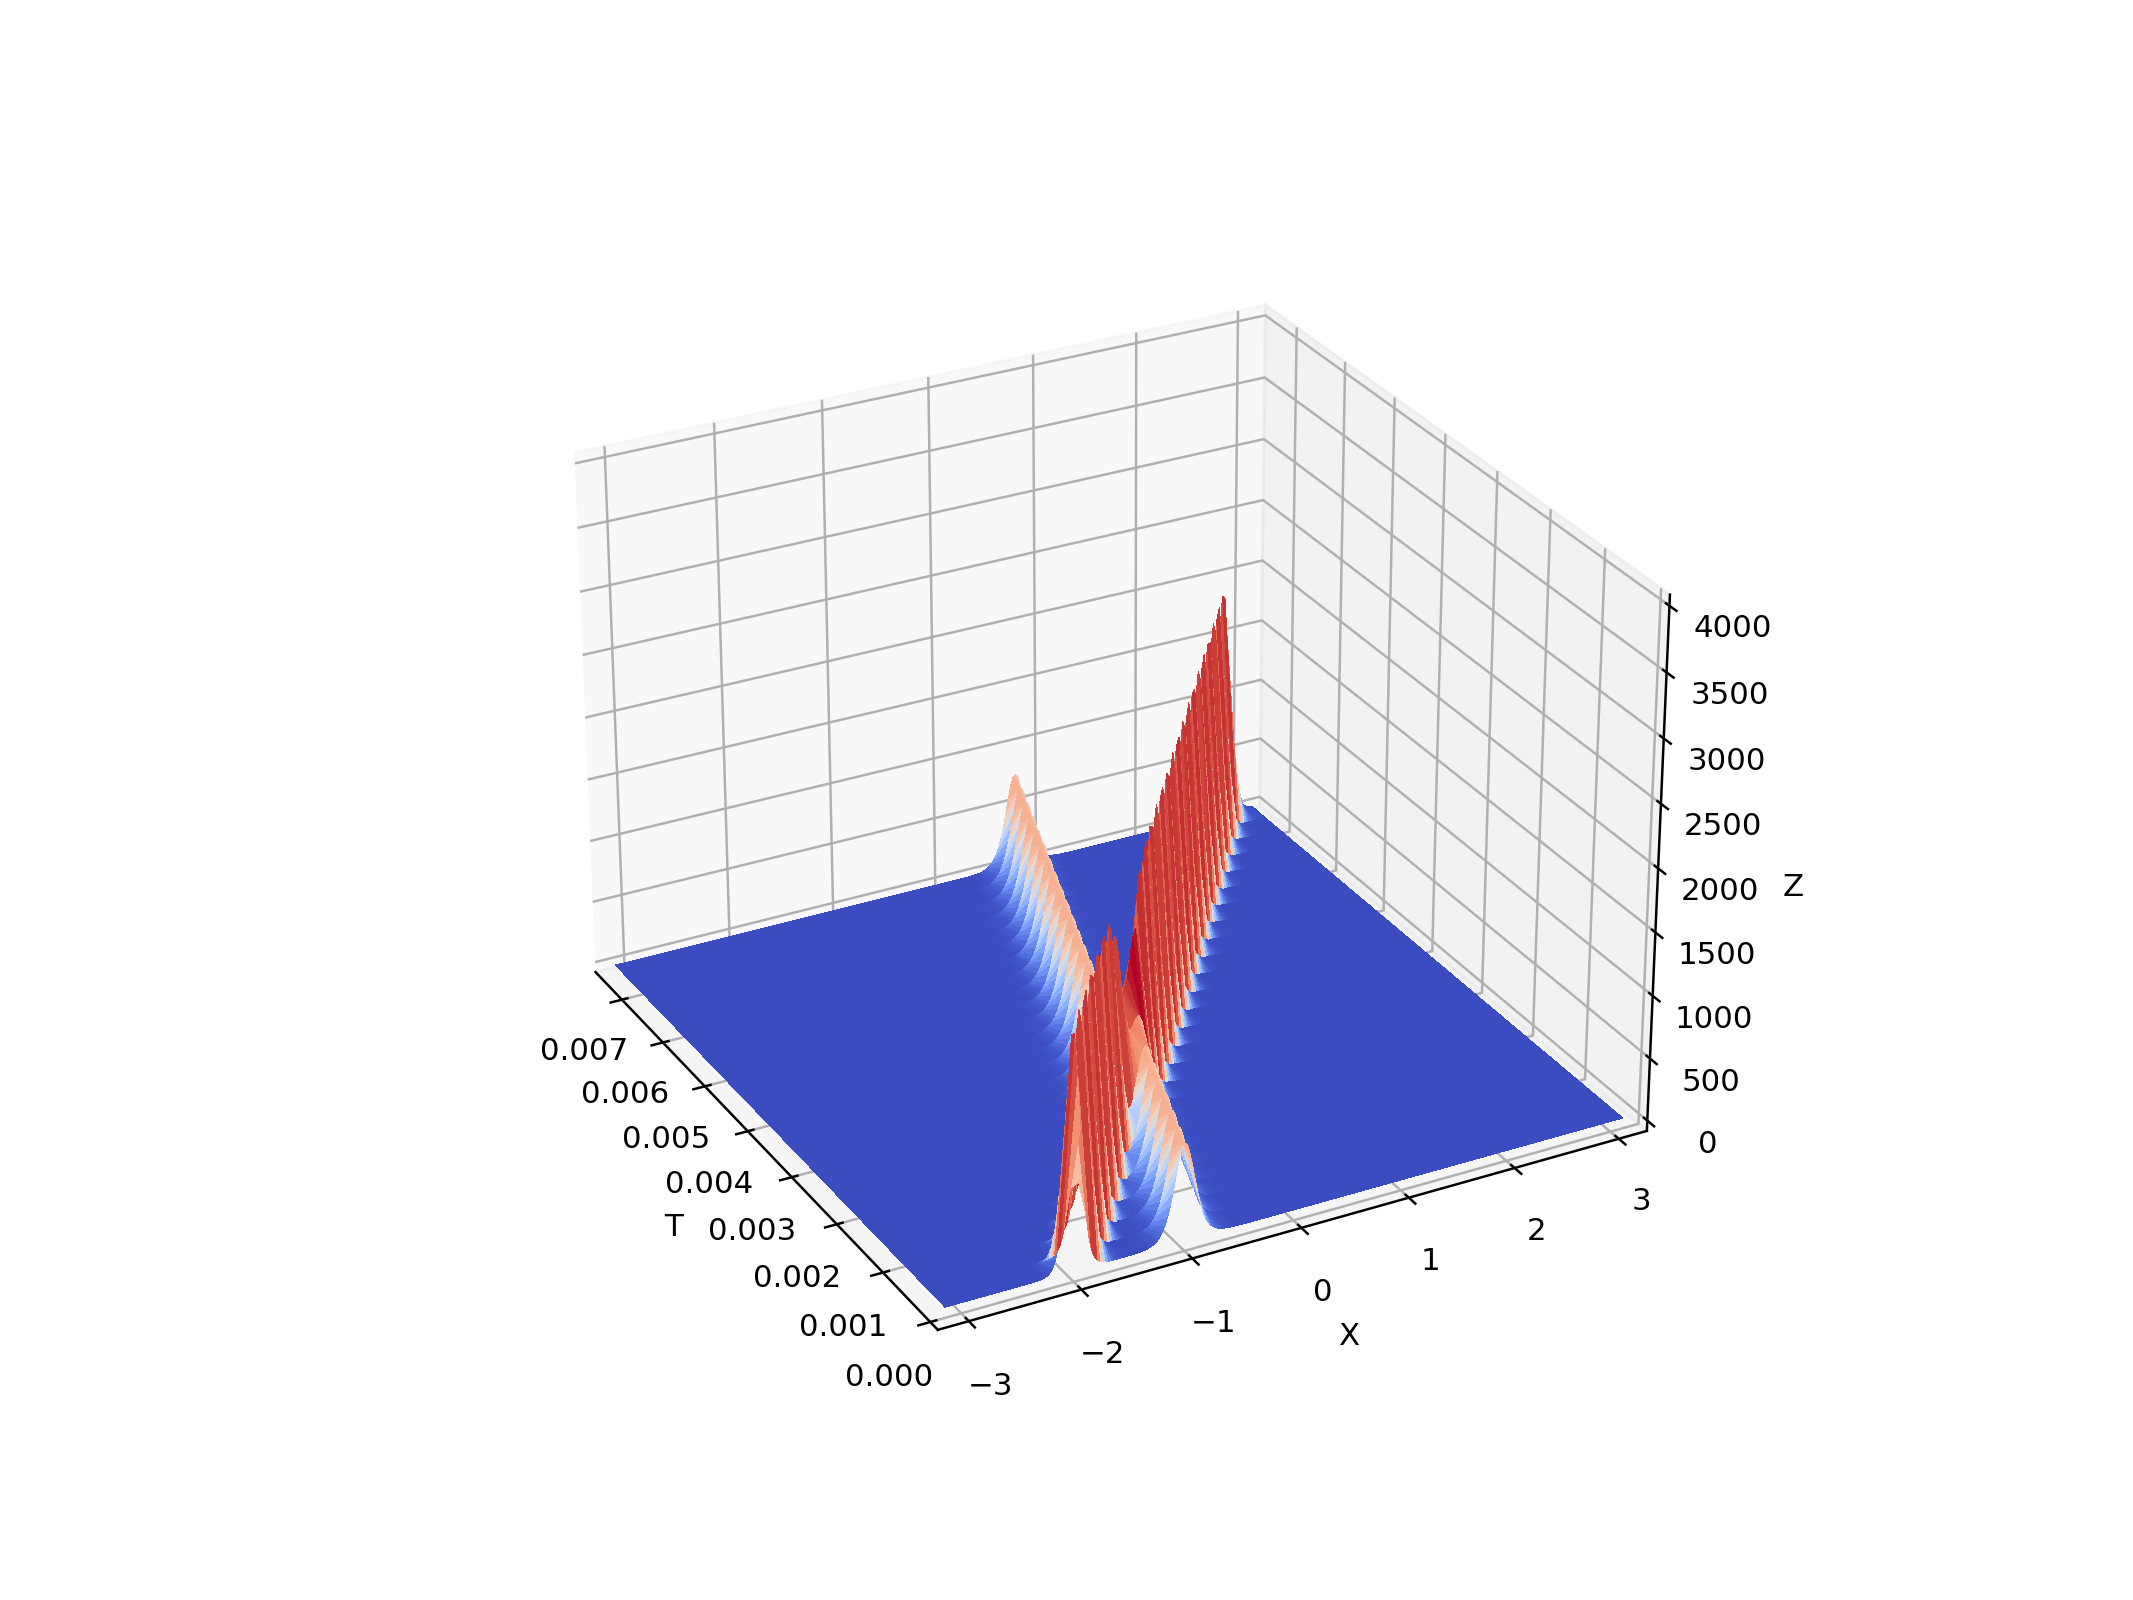

In [4]:
def problem2(s1 = 25**2, s2 = 16**2, shift1 = 2, shift2 = 1, N=256):

    # Space discretization
    x = (2.*np.pi/N)*np.arange(-N/2, N/2).reshape(N, 1) 
    
    # wave numbers
    k = np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0, 1))).reshape(N,)
    ik3 = 1j*k**3.
    
    # initial conditions
    y1 = 3*s1/(np.cosh(np.sqrt(s1)*(x + shift1)/2)**2).reshape(N,) # initial conditions
    y2 = 3*s2/(np.cosh(np.sqrt(s2)*(x + shift2)/2)**2).reshape(N,)
    y0 = y1 + y2
    
    # ODE to solve in Fourier space
    def G_unscaled(t,y):
        out = -.5*1j*k*fft(ifft(y, axis=0)**2., axis=0) + ik3*y
        return out

    # Solves the ODE.
    max_t = .0075
    dt = .02*N**(-2.)
    max_tsteps = int(round(max_t/dt))
    # convert initial condition to Fourier space
    y0 = fft(y0,axis=0)
    # solve for Y
    T, Y = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)
    # Using the variable stride, we step through the data,
    # applying the inverse fourier transform to obtain u.
    # These values will be plotted.
    stride = int(np.floor((max_t/25.)/dt))
    uvalues, tvalues = np.real(ifft(y0, axis=0)).reshape(N, 1), np.array(0.).reshape(1, 1)
    for n in range(1, max_tsteps+1):
        if np.mod(n, stride) == 0:
            t = n*dt
            u = np.real(ifft(Y[n], axis=0) ).reshape(N, 1)
            uvalues = np.concatenate((uvalues, np.nan_to_num(u)), axis=1)
            tvalues = np.concatenate((tvalues, np.array(t).reshape(1,1)), axis=1)

    # plotting
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.gca(projection='3d')
    ax.view_init(elev=45., azim=150)
    tv, xv = np.meshgrid(tvalues, x, indexing='ij')
    surf = ax.plot_surface(tv, xv, uvalues.T, rstride=1, cstride=1, 
                           cmap=cm.coolwarm, linewidth=0, antialiased=False)
    tvalues = tvalues[0]; ax.set_xlim(tvalues[0], tvalues[-1])
    ax.set_ylim(pi, -pi);
    ax.set_zlim(0., 4000.)
    ax.set_xlim(0., 0.0075)
    ax.set_xlabel('T'); ax.set_ylabel('X'); ax.set_zlabel('Z')
    plt.show()    
    
    
    return
problem2()

# Problem 3

Consider again equation (19.2). The linear term in this equation is $ik^3Y$ . This
term contributes much of the exponential growth in the ODE, and responsible for how short
the time step must be to ensure numerical stability. Make the substitution $Z = e^{−ik^3t}Y$ and
find a similar ODE for Z. Use the resulting equation to solve the previous problem and plot the solution.
When we make the given substitution we find that.
Our substitution says that
\begin{align}
Y = \frac{Z}{e^{-ik^3t}}
\end{align}

So then $\frac{\partial Y}{\partial t}$ is

\begin{align}
Y_t = \frac{\partial }{\partial t} Ze^{-ik^3t} =\frac{Z_t e^{-ik^{3}t} - Z\left(-ik^3 e^{-ik^{3}t}\right)}{\left(e^{-ik^{3}t}\right)^2} = \frac{Z_t + Zik^3}{e^{-ik^3t}}
\end{align}

and the right hand side of the differential equation gives us

\begin{align}
 \frac{-ik}{2}\mathcal{F}\left(\mathcal{F}^{-1}(Y)^2\right) + ik^3 Y &=  \frac{-ik}{2}\mathcal{F}\left(\mathcal{F}^{-1}\left(\frac{Z}{e^{-ik^3t}}\right)^2\right) + ik^3 \left(\frac{Z}{e^{-ik^3t}}\right)\\
\end{align}

So then we have that

\begin{align}
&\frac{Z_t + Zik^3}{e^{-ik^3t}} = \frac{-ik}{2}\mathcal{F}\left(\mathcal{F}^{-1}\left(\frac{Z}{e^{-ik^3t}}\right)^2\right) + ik^3 \left(\frac{Z}{e^{-ik^3t}}\right)\\
& \implies Z_t =  \frac{-ike^{ik^3t}}{2}\mathcal{F}\left(\mathcal{F}^{-1}\left(\frac{Z}{e^{-ik^3t}}\right)^2\right)
\end{align}

Note that the initial conditions remain the same since $\left.e^{-ik^3t}\right|_{t=0} =1$.
The procedure then is to solve the PDE in $Z$ and convert it back to $Y$ to avoid the numerical instability. 

<IPython.core.display.Javascript object>


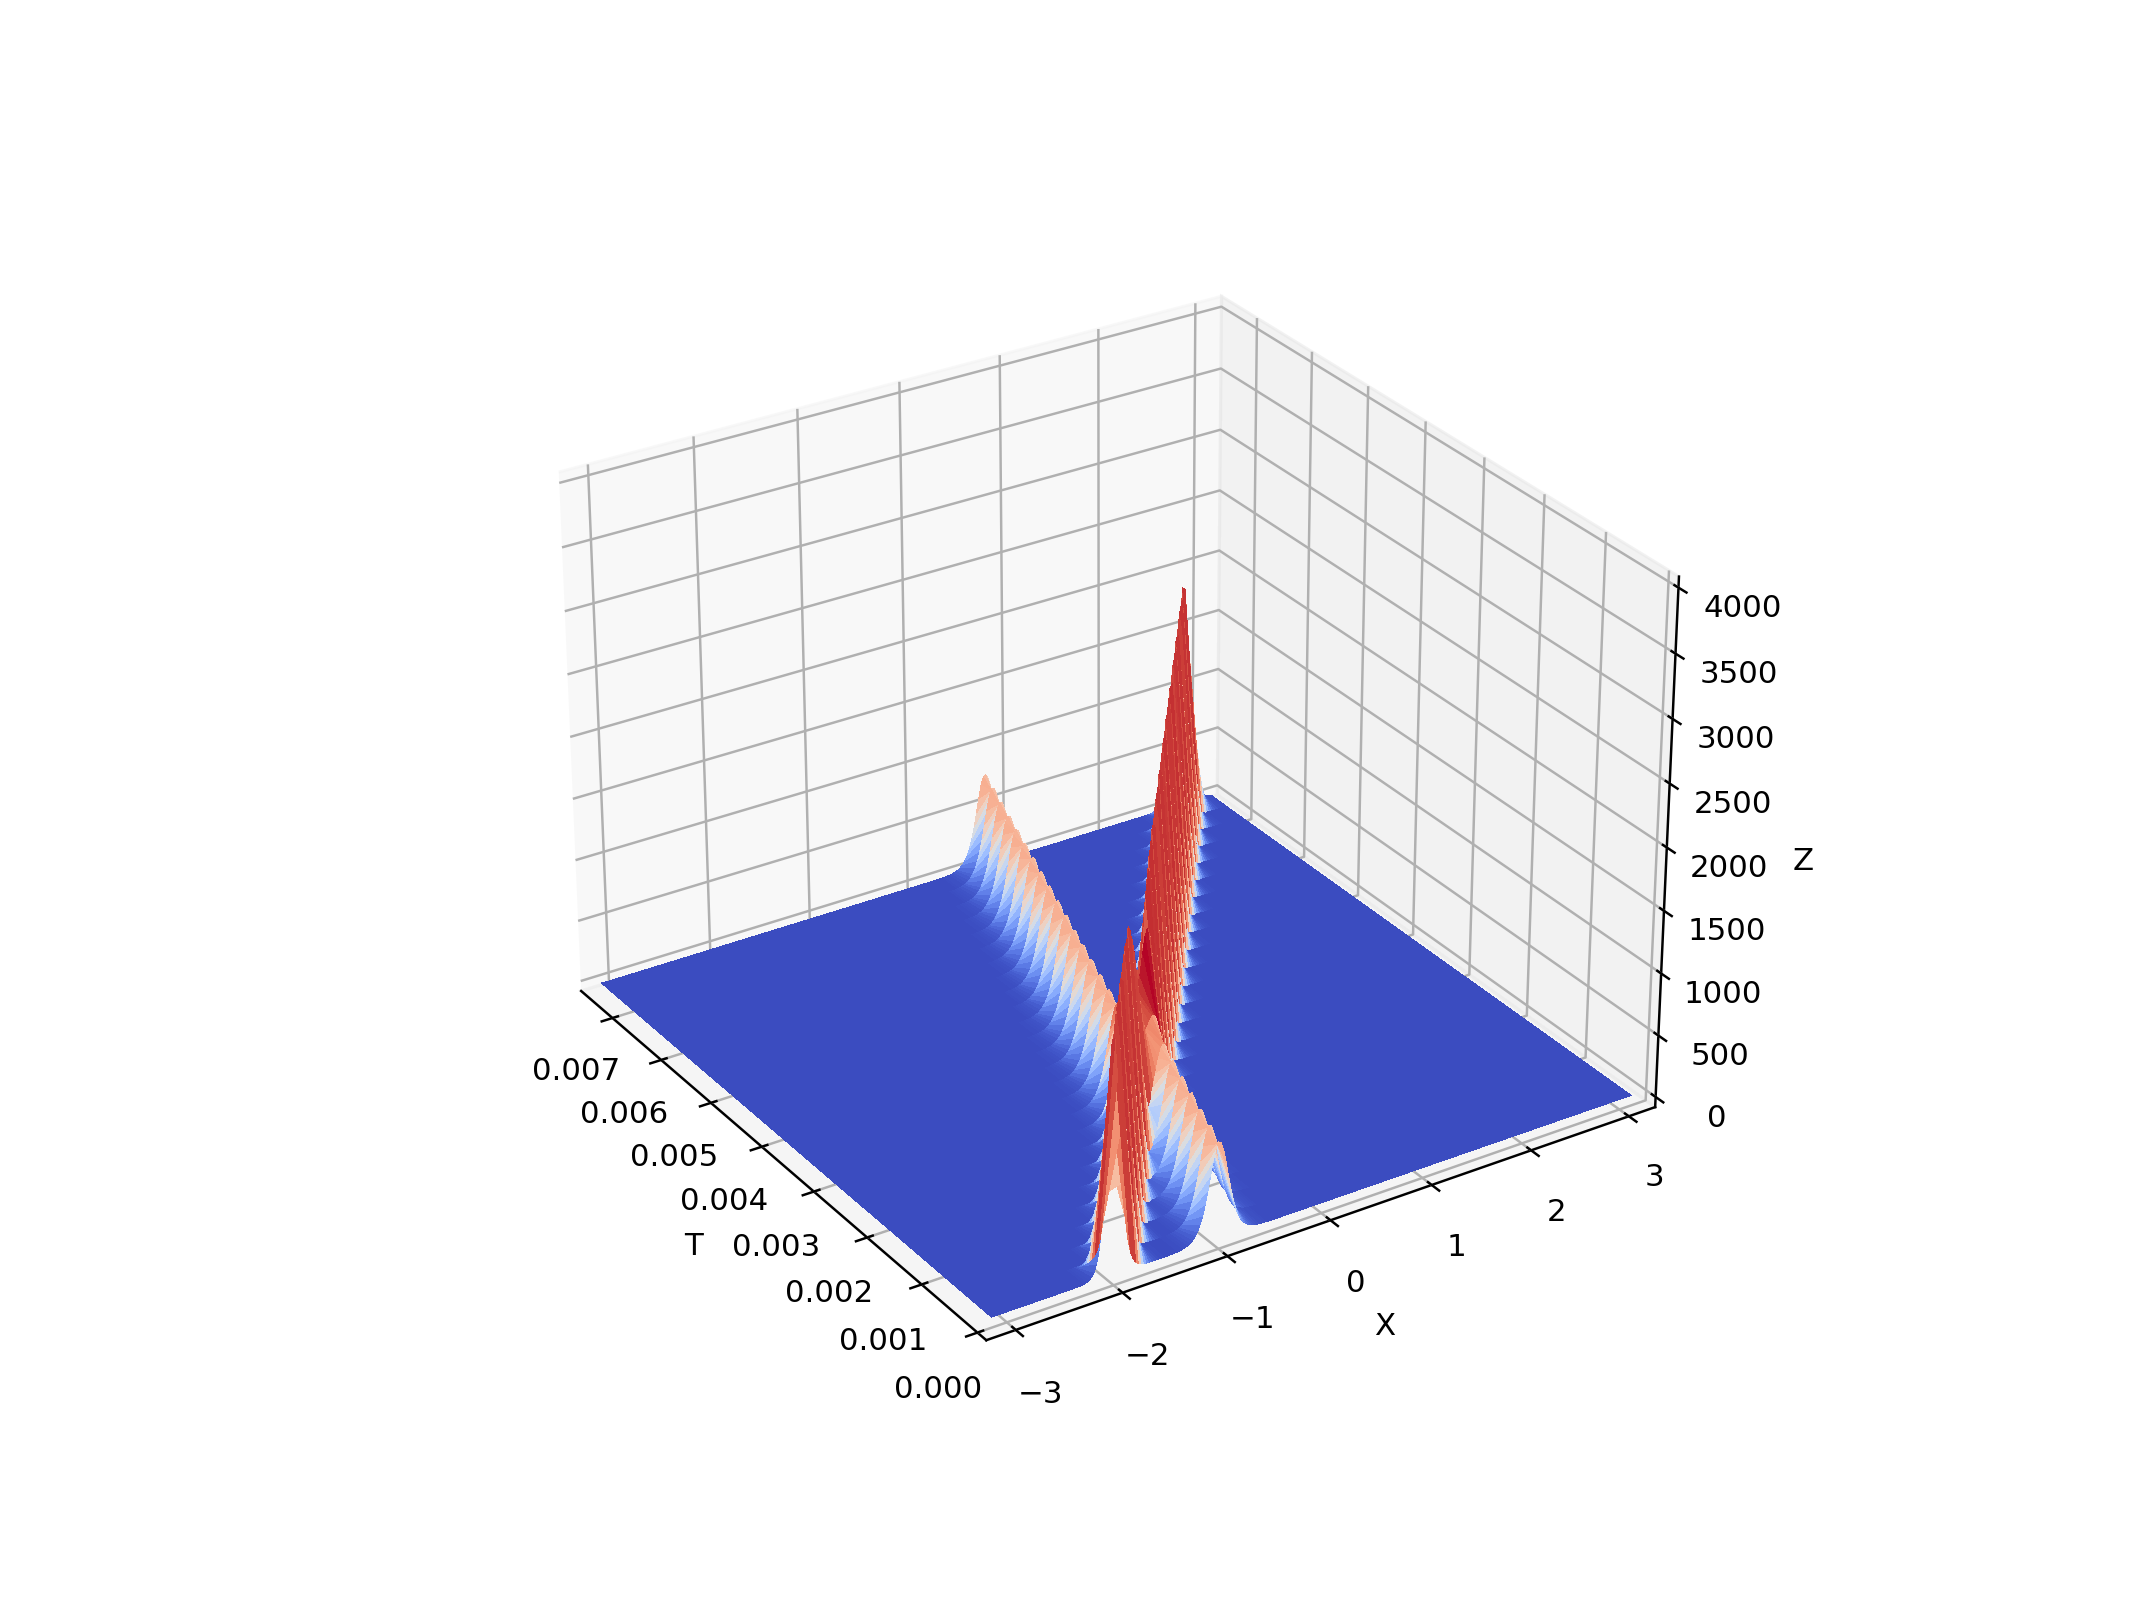

In [5]:
def problem3(s1 = 25**2, s2 = 16**2, shift1 = 2, shift2 = 1, N=256):
    
    # Space discretization
    x = (2.*np.pi/N)*np.arange(-N/2, N/2).reshape(N, 1)
    
    # get wave numbers
    k = np.concatenate(( np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0, 1))).reshape(N,)
    ik3 = 1j*k**3.
    
    # initial conditions
    y1 = 3*s1/(np.cosh(np.sqrt(s1)*(x + shift1)/2)**2).reshape(N,) 
    y2 = 3*s2/(np.cosh(np.sqrt(s2)*(x + shift2)/2)**2).reshape(N,)
    y0 = y1+y2

    # ODE to solve for Z in Fourier space
    def G_unscaled(t, Z):
        out = -0.5*np.exp(-1*ik3*t)*1j*k*fft((ifft(Z*np.exp(ik3*t)))**2, axis=0)
        return out
    
    # Solves the ODE.
    max_t = .0075
    dt = .02*N**(-2.)

    # get max time steps
    max_tsteps = int(round(max_t/dt))
    # convert y0 into Fourier space
    y0 = fft(y0, axis=0)
    # solve for Z
    T,Z = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)
    
    # convert back to Y in Fourier space
    Y = np.exp(ik3*(T.reshape(-1, 1)))*Z
    
    # Using the variable stride, we step through the data,
    # applying the inverse fourier transform to obtain u.
    # These values will be plotted.
    stride = int(np.floor((max_t/25.)/dt))
    uvalues, tvalues = np.real(ifft(y0,axis=0)).reshape(N,1), np.array(0.).reshape(1, 1)
    for n in range(1, max_tsteps+1):
        if np.mod(n, stride) == 0:
            t = n*dt
            u = np.real(ifft(Y[n], axis=0)).reshape(N, 1)
            uvalues = np.concatenate((uvalues, np.nan_to_num(u)), axis=1)
            tvalues = np.concatenate((tvalues, np.array(t).reshape(1, 1)), axis=1)

    # plotting
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.gca(projection='3d')
    ax.view_init(elev=45., azim=150)
    tv, xv = np.meshgrid(tvalues, x, indexing='ij')
    surf = ax.plot_surface(tv, xv, uvalues.T, rstride=1, cstride=1, 
                           cmap=cm.coolwarm, linewidth=0, antialiased=False)
    tvalues = tvalues[0]; ax.set_xlim(tvalues[0], tvalues[-1])
    ax.set_ylim(pi, -pi);
    ax.set_zlim(0., 4000.)
    ax.set_xlim(0., 0.0075)
    ax.set_xlabel('T'); ax.set_ylabel('X'); ax.set_zlabel('Z')
    plt.show()    
    
    return
problem3()